In [1]:
import sys

# adapt paths
sys.path.append("/home/cctrotte/code/pysurvival/")

Number of data-points: 1000 - Number of events: 534.0


C-index: 0.51


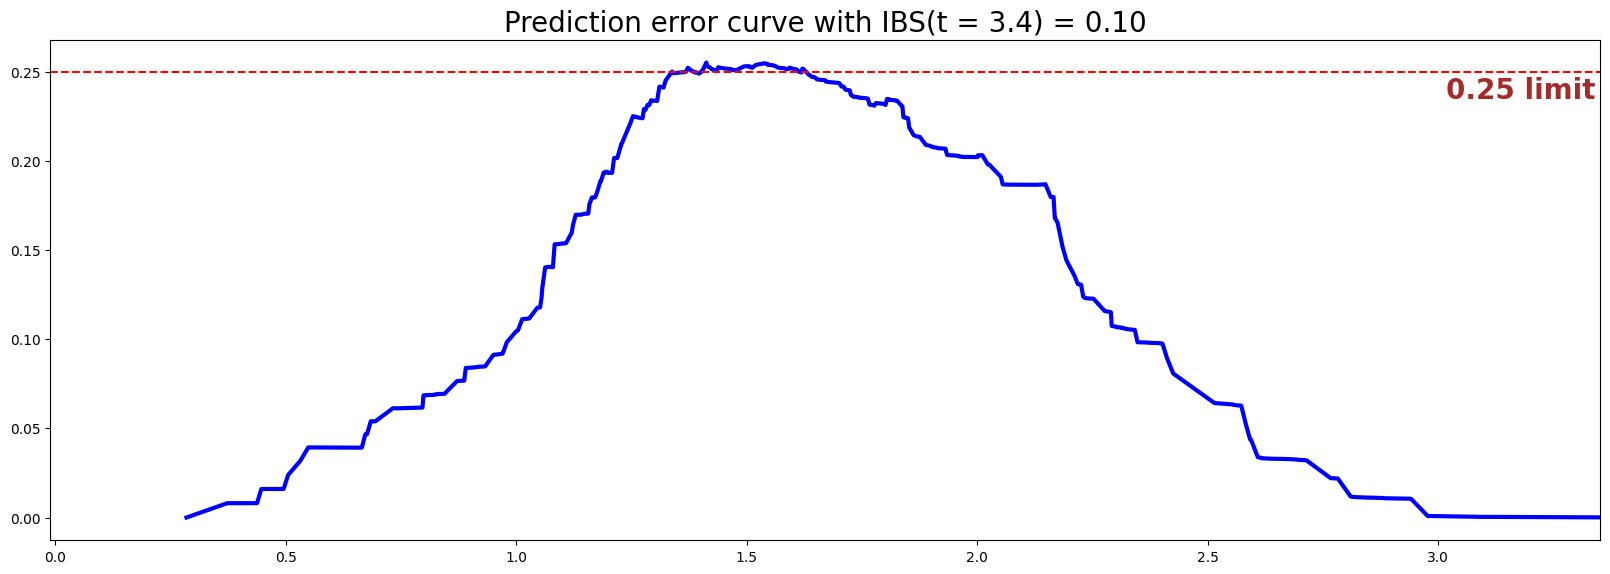

In [2]:
 #### 1 - Importing packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.models_mine import MineNonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.metrics import concordance_index_mine
from sklearn.preprocessing import StandardScaler
from pysurvival.utils.display import integrated_brier_score
#%matplotlib inline  # To use with Jupyter notebooks

#### 2 - Generating the dataset from a nonlinear Weibull parametric model
# Initializing the simulation model
sim = SimulationModel( survival_distribution = 'weibull',  
                        risk_type = 'Gaussian',
                        censored_parameter = 2.1, 
                        alpha = 0.1, beta=3.2 )

# Generating N random samples 
N = 1000
dataset = sim.generate_data(num_samples = N, num_features=3)

# Showing a few data-points 
dataset.head(2)

#### 3 - Creating the modeling dataset
# Defining the features
features = sim.features

# Building training and testing sets #
index_train, index_test = train_test_split( range(N), test_size = 0.2)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E input
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train['time'].values, data_test['time'].values
E_train, E_test = data_train['event'].values, data_test['event'].values
X_valid, T_valid, E_valid = X_test, T_test, E_test

#### 4 - Creating an instance of the NonLinear CoxPH model and fitting 
# the data.

# Defining the MLP structure. Here we will build a 1-hidden layer 
# with 150 units and `BentIdentity` as its activation function
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Building the model
nonlinear_coxph = MineNonLinearCoxPHModel(structure=structure, auto_scaler = False) 
nonlinear_coxph.fit(X_train, T_train, E_train, X_valid, T_valid, E_valid, lr=1e-3, 
    init_method='xav_uniform')


#### 5 - Cross Validation / Model Performances
c_index = concordance_index(nonlinear_coxph, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(nonlinear_coxph, X_test, T_test, E_test, 
    t_max=10, figure_size=(20, 6.5) )


In [5]:
from pysurvival.utils.display import compare_to_actual

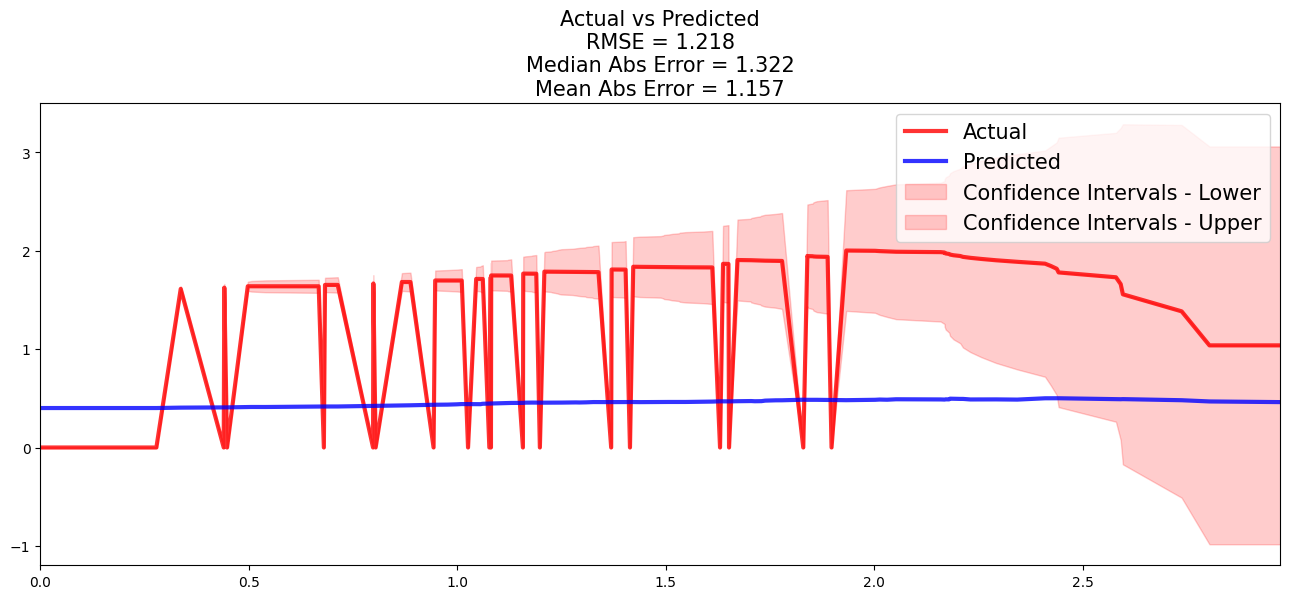

{'root_mean_squared_error': 1.2180014155104495,
 'median_absolute_error': 1.3216656899472183,
 'mean_absolute_error': 1.156555178649944}

In [6]:
compare_to_actual(nonlinear_coxph, X_test, T_test, E_test,
                            is_at_risk = True,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])